In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as random

In [2]:
def spin_lattice(N):
    spin = np.random.choice([-1,1], size=(N, N))

    return spin

In [3]:
def interaction_matrix_J(N, tt):
  

  matrix = 1.1*np.random.uniform(-1, 1, size=(len(tt), N, N, N, N))
  # matrix = np.ones([N,N,N,N])/20
  for t in range(len(tt)):
    for i in range(N):
      for j in range(N):
        matrix[t,i,j,i,j] = 0
  return matrix

interaction_matrix_J(5,[1,2,3]).shape

(3, 5, 5, 5, 5)

Now let's design the matrix h to simulate that suddenly there is bad news at t = 100 (e.g., the company has defrauded or interest rates have been raised), so we set the entire magnetic field as 0 until t = 100 which we set as a negative value. We should see the stock price go down.

In [4]:
def magnetic_field_h(N, tt, t_event_1, duration_event_1, t_event_2, duration_event_2, type_1 = "arb", type_2 = "arb"):

  h_field_t0 = np.zeros([len(np.arange(tt[0],t_event_1,1)),N,N])

  min_h_t = 0
  max_h_t = 0  

  if type_1 == "pos":
    min_h_t = 0
    max_h_t = 0.5
  elif type_1 == "neg":
    min_h_t = -0.5
    max_h_t = 0
  elif type_1 == "arb": # arbitrary, i.e., it affects each person in a random manner
    min_h_t = -0.5
    max_h_t = 0.5

  h_field_1 = np.random.uniform(min_h_t, max_h_t, size = (len(np.arange(t_event_1,t_event_1+duration_event_1,1)),N,N))

  h_field_t0_med = np.zeros([len(np.arange(t_event_1+duration_event_1,t_event_2,1)),N,N])

  if type_2 == "pos":
    min_h_t = 0
    max_h_t = 0.5
  elif type_2 == "neg":
    min_h_t = -0.5
    max_h_t = 0
  elif type_2 == "arb": # arbitrary, i.e., it affects each person in a random manner
    min_h_t = -0.5
    max_h_t = 0.5

  h_field_2 = np.random.uniform(min_h_t, max_h_t, size = (len(np.arange(t_event_2,t_event_2+duration_event_2,1)),N,N))

  h_field_t0_fin = np.zeros([len(np.arange(t_event_2+duration_event_2,tt[-1]+1,1)),N,N])


  h_field_t = np.concatenate((h_field_t0,h_field_1,h_field_t0_med,h_field_2,h_field_t0_fin))

  return h_field_t

# magnetic_field_h(2,[0,1,2,3,4,5,6,7,8,9], 5, 2).shape

In [5]:
def flip_energy(spin, interaction_matrix_J, matrix_h, i, j, t):
  E = 0
  E += 2*spin[i,j]*matrix_h[t,i,j]
  N = spin.shape[0]
  for k in range(N):
    for l in range(N):
      E += 2*interaction_matrix_J[t,i,j,k,l]*spin[i,j]*spin[k,l]

  return E

This function selects which traders are actually trading during the period since there can be inactive traders.

In [6]:
def active_agents(AA,N):

    
    x = random.sample(range(0, N), AA)
    y = random.sample(range(0, N), AA)

    return x, y

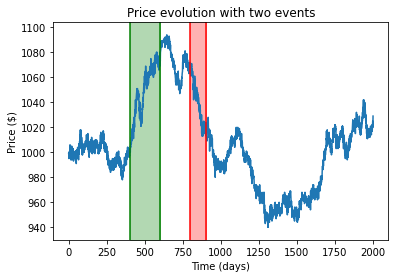

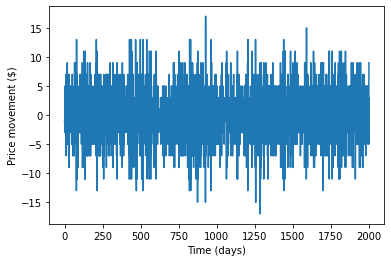

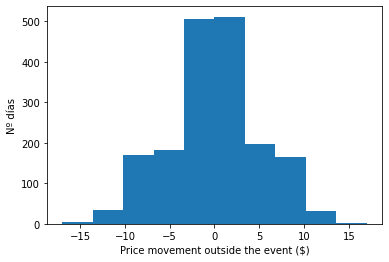

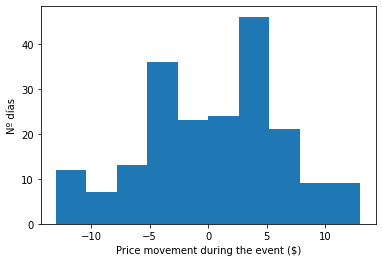

In [13]:
N = 5 # 5x5 = 25 traders
AA = N # All the traders are active
t0 = 0
tmax = 2000 # Maximum time (days)
TT = np.linspace(1,10,11)
time_event_1 = 400 # Time at which event 1 starts
duration_event_1 = 200 # Duartion of event 1
type_event_1 = "pos"

time_event_2 = 800 # Time at which event 2 starts
duration_event_2 = 100 # Duartion of event 2
type_event_2 = "neg"

tt = np.arange(t0,tmax + 1, 1)
cum_mag = 1000 # La ponemos a 1000$
spin = spin_lattice(N)
J = interaction_matrix_J(N,tt)
h = magnetic_field_h(N, tt, time_event_1, duration_event_1, time_event_2, duration_event_1, type_event_1, type_event_2)
cum_mag_list = []
inst_mag_list = []
TT = [20] # Temperatures at which to run the simulation. Note that T here is dimensionless

# Run the Monte Carlo simulation to let the system evolve
for T in TT:
  for t in range(len(tt)):
      M_inst = 0
      AA_x, AA_y = active_agents(AA,N)
      for i in AA_x:
          for j in AA_y:

              flip_E = flip_energy(spin, J, h, i, j, t)
              uni_sample = random.uniform(0, 1)

              if flip_E <= 0:
                  spin[i, j] = -spin[i, j]

              elif (flip_E > 0) and (np.exp(-flip_E/T) >= uni_sample):
                  spin[i, j] = -spin[i, j]

              else:
                  spin[i, j] = spin[i, j]

              cum_mag += spin[i, j]
              M_inst += spin[i,j] 

      cum_mag_list.append(cum_mag)
      inst_mag_list.append(M_inst)

plt.plot(tt, cum_mag_list)

# Define the y-range for filling
y_start = min(cum_mag_list)-10
y_end = max(cum_mag_list)+10

# Plot the vertical lines and the filled area:
if type_event_1 == "pos":
  plt.axvline(x=time_event_1, color='green')
  plt.axvline(x=time_event_1+duration_event_1, color='green') 
  plt.fill_betweenx([y_start, y_end], time_event_1, time_event_1+duration_event_1, color="green",alpha=0.3)
elif type_event_1 == "neg":
  plt.axvline(x=time_event_1, color='red')
  plt.axvline(x=time_event_1+duration_event_1, color='red')
  plt.fill_betweenx([y_start, y_end], time_event_1, time_event_1+duration_event_1, color="red",alpha=0.3)
if type_event_2 == "pos":
  plt.axvline(x=time_event_2, color='green')
  plt.axvline(x=time_event_2+duration_event_2, color='green') 
  plt.fill_betweenx([y_start, y_end], time_event_2, time_event_2+duration_event_2, color="green",alpha=0.3)
elif type_event_2 == "neg":
  plt.axvline(x=time_event_2, color='red')
  plt.axvline(x=time_event_2+duration_event_2, color='red')
  plt.fill_betweenx([y_start, y_end], time_event_2, time_event_2+duration_event_2, color="red",alpha=0.3)


plt.ylim(y_start, y_end)
plt.xlabel("Time (days)")
plt.ylabel("Price ($)")
plt.title("Price evolution with two events")
plt.savefig("Simulation Event.png")
plt.show()

plt.plot(tt, inst_mag_list)
plt.xlabel("Time (days)")
plt.ylabel("Price movement ($)")
plt.show()

plt.hist(inst_mag_list[0:time_event_1]+inst_mag_list[time_event_1+duration_event_1::],bins=10)
plt.ylabel("Nº días")
plt.xlabel("Price movement outside the event ($)")
plt.show()

plt.hist(inst_mag_list[time_event_1:time_event_1+duration_event_1],bins=10)
plt.ylabel("Nº días")
plt.xlabel("Price movement during the event ($)")
plt.show()